# Dependencies

In [12]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#plt.style.use('mypaper')

import warnings
warnings.filterwarnings('ignore')

# Calibration Results

## Concentrations of Pelikan Dyes in aqueous solution

As we do not know the composition or concentration of the Pelikan inks, for the following labelling of dilutions we will assume that the initial concentration of the respective inks is 

$$c_0 = \frac{100\,  U_{dye}}{mL} \ , $$ 

where $U_{dye}$ is the unknown quantity unit of dye present in 1 mL of $H_2 O$. 
Under this assumption it follows that a volume $V_{c_0}$ of ink with concentration $c_0$ will have a quantity of dye

$$ x_{c_0} \, [U_{dye}]= V_{c_0}\,[\mu L] \times \frac{1\,mL}{1000\,\mu L} \times c_0 $$

and a dilution of the latter in a volume $V_{H_2O}$ will have a concentration $c_{dilution} = c_d$ according to

$$ c_d (V_{c_0}, V_{tot,d}) =  \frac{x_{c_0}}{V_{tot, d}} = \frac{V_{c_0}\,[\mu L] }{V_{tot, d}} \times \frac{1\,mL}{1000\,\mu L} \times c_0  $$

Then, with $V_{G, c_0} = 75 \mu L$ and $V_{tot, d} = 1.5\, mL$ for Pelikan Green and $V_{R, c_0} = 150 \,\mu L$ and $V_{tot, d} = 1.5\, mL$ for Pelikan Red it follows:

$$c_{d1,Green} = \frac{5 \,U_{dye}}{mL} \\[.5cm]
c_{d1,Red} = \frac{10 \,U_{dye}}{mL}$$

### Pelikan Green

In [2]:
v_diG = np.array([0.15, 
                  0.075, 
                  0.0375, 
                  0.025, 
                  0.01875, 
                  0.015, 
                  0.01, 
                  0.])

c_d1G = 5
v_tot = 1.5
c_diG = v_diG*c_d1G/v_tot
print('Volums of Dilution 1:', v_diG, 'mL')
print('Volumns of H2O to add:', v_tot-v_diG, 'mL')

Volums of Dilution 1: [ 0.15     0.075    0.0375   0.025    0.01875  0.015    0.01     0.     ] mL
Volumns of H2O to add: [ 1.35     1.425    1.4625   1.475    1.48125  1.485    1.49     1.5    ] mL


In [17]:
for c in c_diG:
    print(c)

0.5
0.25
0.125
0.0833333333333
0.0625
0.05
0.0333333333333
0.0


### Pelikan Red

In [4]:
v_diR = 2*np.array([0.15, 
                  0.075, 
                  0.0375, 
                  0.025, 
                  0.01875, 
                  0.015, 
                  0.01, 
                  0.])
c_d1R = 10
v_tot = 1.5
c_diR = v_diR*c_d1R/v_tot
print('Volums of Dilution 1:', v_diR, 'mL')
print('Volumns of H2O to add:', v_tot-v_diR, 'mL')

Volums of Dilution 1: [ 0.3     0.15    0.075   0.05    0.0375  0.03    0.02    0.    ] mL
Volumns of H2O to add: [ 1.2     1.35    1.425   1.45    1.4625  1.47    1.48    1.5   ] mL


In [38]:
for c in c_diR:
    print(c)

2.0
1.0
0.5
0.333333333333
0.25
0.2
0.133333333333
0.0


## Data Processing

*Load data using custom database object*

In [36]:
from modules.MyDB import MyDB as MyDB

In [61]:
db = MyDB()
#db.list_tags()
db.list_experiments()

interactive(children=(Dropdown(description='choose tag:', index=2, options=('TwinChips_X2_Calibration20181122_Green', 'TwinChips_X2_Calibration20181122_Red', ''), value=''), Output()), _dom_classes=('widget-interact',))

*Sort by label (last entry in tags)*

*Define [Spectral Absorbance](https://en.wikipedia.org/wiki/Absorbance#Spectral_absorbance)*

In [7]:
def A(i, i0):
    return np.log10(i0/i) 

*[Stream](https://bokeh.pydata.org/en/latest/docs/reference/models/sources.html#bokeh.models.sources.ColumnDataSource.stream) data to ColumnDataSource*

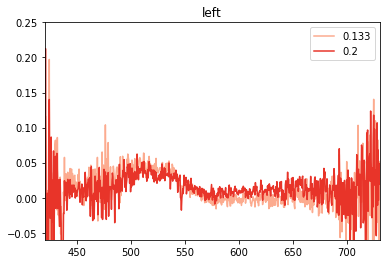

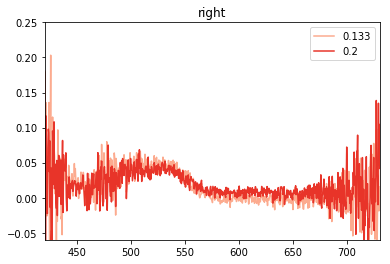

In [62]:
# sort by last entry in tags, which was the label in MyMeasurement.save_intensities -> concentration
def label_to_float(c):
    return float(c)
db.readouts.sort('tags', index=-1, getter_func=label_to_float)

# define sensor name for creating the data subset
sensors = ['left','right' ]
colormap = cm.Reds

for sensor in sensors:
    number_of_lines = len(db.readouts.select(sensor))
    cm_subsection = np.linspace(0.3, 1, number_of_lines)
    colors = [colormap(x) for x in cm_subsection]
    #from bokeh.palettes import Greens as palette
    #from bokeh.plotting import figure, output_file, show

    #palette = ['black', 'purple', 'blue', 'green', 'yellow', 'orange','red']
    #output_file = 'testplot.html'
    #p = figure()
    fig = plt.figure()
    p = fig.add_subplot(111, title=sensor)
    # define reference; water (c = 0.0) as "i0"
    with np.load(db.readouts.select(sensor)[0]) as i0:
        i0_mean = np.mean(i0['intensities'], axis=0)

    # stream data-subset as Absorbance to ColumnDataSource "PlotData"
    for i, readout in enumerate(db.readouts.select(sensor)[1:]):    
        with np.load(readout) as data:
            i_mean = np.mean(data['intensities'], axis=0)
            data_to_add = {
                'wavelength/nm': db.spectrometers[data['detector'].item()],
                'Spectral Absorbance/A.U.': A(i_mean, i0_mean)
            }
            #PlotData.stream(data_to_add)
            p.plot(data_to_add['wavelength/nm'], data_to_add['Spectral Absorbance/A.U.'],label=str(round(float(data['tags'][-1]),3)), color=colors[i]
                )
            p.legend()
            p.set_xlim((420,730))
            p.set_ylim((-.06,.25))
        
#show(p)

In [37]:
plt.savefig('X2_r_Red.svg')